In [1]:
import os
import csv
import json
import shelve

from PIL import Image
import matplotlib.pyplot as plt
from util.visualize import show_pyg_graph
import networkx as nx
from IPython.display import clear_output
from tqdm import tqdm

import spacy
nlp = spacy.load("en_core_web_sm")

from data.ag.action_genome import AG

%load_ext autoreload


In [2]:
root = '/data/Datasets/ag/'
subset_filename = 'data/ag/subset.json'
ag = AG(root)

folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/AKKWU.mp4 does not exist
folder /data/Datasets/ag/frames/QQ9RN.mp4 does not exist
folder /data/Datasets/ag/frames/8EYHC.mp4 does not exist
folder /data/Datasets/ag/frames/8EYHC.mp4 does not exist
folder /data/Datasets/ag/frames/RTULL.mp4 does not exist
folder /data/Datasets/ag/frames/VKLP7.mp4 does not exist
folder /data/Datasets/ag/frames

In [3]:
for a in ag.action_classes:
    print(a)

c000 Holding some clothes
c001 Putting clothes somewhere
c002 Taking some clothes from somewhere
c003 Throwing clothes somewhere
c004 Tidying some clothes
c005 Washing some clothes
c006 Closing a door
c007 Fixing a door
c008 Opening a door
c009 Putting something on a table
c010 Sitting on a table
c011 Sitting at a table
c012 Tidying up a table
c013 Washing a table
c014 Working at a table
c015 Holding a phone/camera
c016 Playing with a phone/camera
c017 Putting a phone/camera somewhere
c018 Taking a phone/camera from somewhere
c019 Talking on a phone/camera
c020 Holding a bag
c021 Opening a bag
c022 Putting a bag somewhere
c023 Taking a bag from somewhere
c024 Throwing a bag somewhere
c025 Closing a book
c026 Holding a book
c027 Opening a book
c028 Putting a book somewhere
c029 Smiling at a book
c030 Taking a book from somewhere
c031 Throwing a book somewhere
c032 Watching/Reading/Looking at a book
c033 Holding a towel/s
c034 Putting a towel/s somewhere
c035 Taking a towel/s from somewh

In [4]:
for a in ag.verb_classes:
    print(a)

v000 awaken
v001 close
v002 cook
v003 dress
v004 drink
v005 eat
v006 fix
v007 grasp
v008 hold
v009 laugh
v010 lie
v011 make
v012 open
v013 photograph
v014 play
v015 pour
v016 put
v017 run
v018 sit
v019 smile
v020 sneeze
v021 snuggle
v022 stand
v023 take
v024 talk
v025 throw
v026 tidy
v027 turn
v028 undress
v029 walk
v030 wash
v031 watch
v032 work


In [8]:
for a in sorted(ag.action_verb_map.items(), key=lambda x: x[1]):
    print(a)

(133, 0)
(146, 0)
(6, 1)
(25, 1)
(39, 1)
(46, 1)
(89, 1)
(112, 1)
(142, 1)
(147, 2)
(55, 3)
(148, 3)
(106, 4)
(65, 5)
(129, 5)
(156, 5)
(7, 6)
(103, 6)
(136, 6)
(140, 6)
(144, 6)
(141, 7)
(0, 8)
(15, 8)
(20, 8)
(26, 8)
(33, 8)
(40, 8)
(47, 8)
(53, 8)
(61, 8)
(67, 8)
(70, 8)
(76, 8)
(84, 8)
(93, 8)
(98, 8)
(107, 8)
(115, 8)
(118, 8)
(128, 8)
(137, 8)
(85, 9)
(131, 9)
(149, 9)
(122, 10)
(124, 10)
(134, 10)
(66, 11)
(8, 12)
(21, 12)
(27, 12)
(41, 12)
(48, 12)
(90, 12)
(113, 12)
(143, 12)
(87, 13)
(16, 14)
(52, 14)
(108, 15)
(1, 16)
(9, 16)
(17, 16)
(22, 16)
(28, 16)
(34, 16)
(42, 16)
(49, 16)
(54, 16)
(62, 16)
(68, 16)
(71, 16)
(77, 16)
(81, 16)
(86, 16)
(99, 16)
(109, 16)
(116, 16)
(119, 16)
(130, 16)
(150, 17)
(10, 18)
(11, 18)
(59, 18)
(123, 18)
(125, 18)
(135, 18)
(151, 18)
(29, 19)
(94, 19)
(152, 19)
(153, 20)
(72, 21)
(78, 21)
(60, 22)
(154, 22)
(2, 23)
(18, 23)
(23, 23)
(30, 23)
(35, 23)
(43, 23)
(44, 23)
(50, 23)
(56, 23)
(63, 23)
(69, 23)
(73, 23)
(79, 23)
(83, 23)
(100, 23)
(110

In [9]:
for b in ag.object_classes:
    print(b)

__background__
person
bag
bed
blanket
book
box
broom
chair
closet/cabinet
clothes
cup/glass/bottle
dish
door
doorknob
doorway
floor
food
groceries
laptop
light
medicine
mirror
paper/notebook
phone/camera
picture
pillow
refrigerator
sandwich
shelf
shoe
sofa/couch
table
television
towel
vacuum
window


In [5]:
print(len(ag))

33432


INDEX: 481
LABEL: UNMARKED
c008 Opening a door
VIDEO-FRAME-ACTION ID: XHQT1.mp4/000677.png_8
[('person', 'looking_at', 'shoe'), ('shoe', 'in_front_of', 'person'), ('person', 'touching', 'shoe'), ('person', 'holding', 'shoe')]


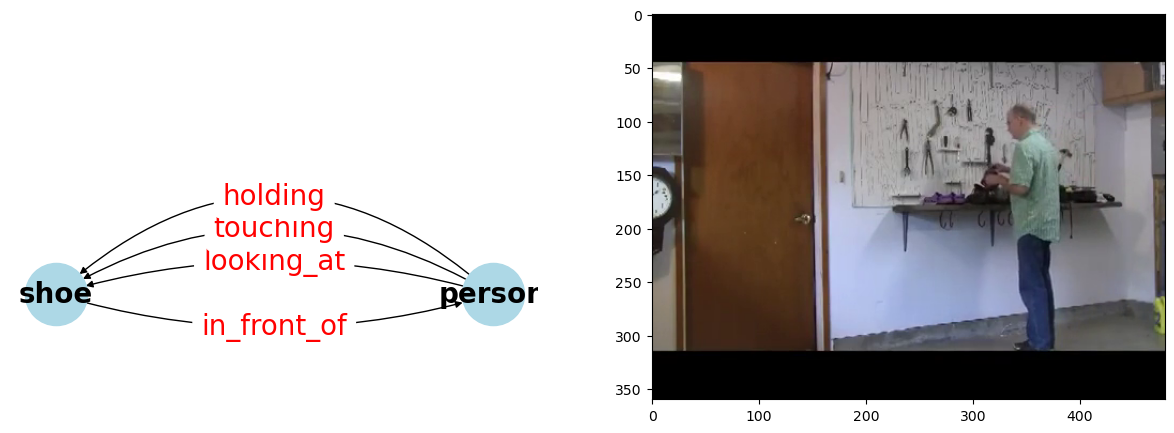

In [53]:
%autoreload

class AGViewer:
    def __init__(self, ag, subset_dict):
        self.ag = ag
        self.subset_dict = subset_dict
        self.index = 0
        self.key = None
        self.message = "Enter/space : navigate by search key | \
                n/p : sequential navigation | \
                j : jump to index | \
                g/b/f/u : label GOOD, BAD, FLAGGED, UNMARKED | \
                k : change search key | \
                q : quit | "

    def view(self, index):
        #check index
        if index < 0:
            _ = input('first index reached, enter to continue')
            index = 0
        elif index >= len(ag):
            _ = input('max index reached, enter to continue')
            index = len(ag) - 1
        
        self.index = index

        clear_output(wait=True)

        id, img, sg, action = ag[index]
        print('INDEX:', index)
        print('LABEL:', subset_dict[id] if id in subset_dict else 'ABSENT')
        print(ag.action_classes[action])
        print('VIDEO-FRAME-ACTION ID:', id)
        nodes = [ag.object_classes[t] for t in sg.node_type]
        print([ (nodes[sg.edge_index[0][i].item()], \
                ag.relationship_classes[t], \
                nodes[sg.edge_index[1][i].item()], \
                ) for i,t in enumerate(sg.edge_type)])

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        show_pyg_graph(sg, ag.object_classes, ag.relationship_classes, layout='circular', curve=0.1, ax=axs[0])
        axs[1].imshow(img)
        plt.show(fig)
    
    def find_next(self, key, prev=False):
        index = self.index
        print(index)

        if prev:
            index -= 1
        else:
            index += 1

        while index <= len(ag) - 1 and index >= 0:

            id, img, sg, action = ag[index]
            if type(key) is str and subset_dict[id] == key:
                return index
            elif type(key) is str and key in id:
                return index
            elif type(key) is int and action == key:
                return index

            if prev:
                index -= 1
            else:
                index += 1

        return None
    
    def next(self, prev=False):
        if self.key is not None:
            next_idx = self.find_next(self.key, prev=prev)
            if next_idx is not None:
                return next_idx
            else:
                _ = input('key not found')
                return self.index
        else:
            return self.index + 1

    def process_command(self, option):
        if option == 'q':
            return None
        
        #navigation
        elif option == '': #next by key
            return self.next()
        elif option == ' ': #previous by key
            return self.next(prev=True)
        elif option == 'n': #immediate next
            return self.index + 1
        elif option == 'p': #immediate prev
            return self.index - 1
        elif option == 'j':
            jump_idx = input('enter index to jump to')
            try:
                jump_idx = int(jump_idx)
                return jump_idx
            except:
                _ = input('invalid index')
                return self.index
        
        #change key
        elif option == 'k':
            new_key = input('enter new key')
            if new_key == '':
                self.key = None
            else:
                try:
                    new_key_int = int(new_key)
                    self.key = new_key_int #setting key to be a certain action class
                except ValueError:
                    self.key = str(new_key) #setting key to be string label
            return self.index

        #labeling
        elif option == 'g': #good
            subset_dict[id] = str(True)
            return self.next()
        elif option == 'b': #bad
            subset_dict[id] = str(False)
            return self.next()
        elif option == 'f': #flag
            subset_dict[id] = 'FLAGGED'
            return self.next()
        elif option == 'u': #flag
            subset_dict[id] = 'UNMARKED'
            return self.next()
        else:
            _ = input('invalid command')
            return self.index


with shelve.open('data/ag/subset_shelve') as subset_dict:
    agview = AGViewer(ag, subset_dict)
    agview.view(0)
    while True:
        answer = input(f"{agview.message}current search key : {str(agview.key)}")
        new_idx = agview.process_command(answer)
        if new_idx is not None:
            agview.view(new_idx)
        else:
            break



In [60]:
#apply some initial heuristics
with shelve.open('data/ag/subset_shelve') as subset_dict:
    for idx in range(100,110):
        print(idx)
        id, img, sg, action = ag[idx]

        obj, verb = ag.action_verb_map[action]

        if obj not in sg.node_type:
            print('action obj not in scene graph')
            print(obj, verb, idx)
            continue

        #subset_dict[id] = ''


100
['opening']
101
['holding']
102
['watching']
103
['walking']
104
['undressing']
105
['grasping']
106
['holding']
107
['putting']
108
['closing']
109
['opening']


In [ ]:
for i,action in enumerate(ag.action_classes):
    words = action.split(' ')[1:]
    
    action = ' '.join(words)
    doc = nlp(action)
    count = 0
    for tok in doc:
        if tok.pos_ == 'VERB':
            count+=1
            print(i, tok.text)
    if count > 1:
        print('double verb:', action)

0 Holding
1 Putting
2 Taking
3 Throwing
4 Tidying
5 Washing
6 Closing
7 Fixing
8 Opening
9 Putting
10 Sitting
11 Sitting
12 Tidying
13 Washing
14 Working
15 Holding
16 Playing
17 Putting
18 Taking
19 Talking
20 Holding
21 Opening
22 Putting
23 Taking
24 Throwing
25 Closing
26 Holding
27 Opening
28 Putting
29 Smiling
30 Taking
31 Throwing
32 Watching
32 Looking
double verb: Watching/Reading/Looking at a book
33 Holding
34 Putting
34 s
double verb: Putting a towel/s somewhere
35 Taking
36 Throwing
36 s
double verb: Throwing a towel/s somewhere
37 Tidying
38 Washing
39 Closing
40 Holding
41 Opening
42 Putting
43 Taking
44 Taking
45 Throwing
46 Closing
47 Holding
48 Opening
49 Putting
50 Taking
51 Watching
53 Holding
54 Putting
55 Putting
56 Taking
57 Taking
58 Throwing
59 Sitting
60 Standing
61 Holding
62 Putting
63 Taking
64 Throwing
65 Eating
66 Making
67 Holding
68 Putting
69 Taking
70 Holding
71 Putting
72 Snuggling
73 Taking
74 Throwing
75 Tidying
76 Holding
77 Putting
78 Snuggling
7

In [22]:
action_hist = {}
for idx in range(len(ag)):
    id, img, sg, action = ag[idx]

    if action not in action_hist:
        action_hist[action] = 0
    action_hist[action]+=1

In [32]:
sorted_actions = sorted(action_hist.items(), key=lambda x: x[1], reverse=True)

for k,v in sorted_actions:
    print(ag.action_classes[k], v)
#plt.hist(list(action_hist.values()), bins=range(1, 10))


c097 Walking through a doorway 1095
c154 Someone is standing up from somewhere 997
c106 Drinking from a cup/glass/bottle 833
c151 Someone is going from standing to sitting 714
c009 Putting something on a table 711
c152 Someone is smiling 684
c061 Holding some food 679
c156 Someone is eating something 633
c059 Sitting in a chair 633
c107 Holding a cup/glass/bottle of something 626
c008 Opening a door 586
c063 Taking food from somewhere 550
c015 Holding a phone/camera 540
c006 Closing a door 499
c001 Putting clothes somewhere 489
c118 Holding a dish 478
c153 Someone is sneezing 451
c113 Opening a closet/cabinet 450
c000 Holding some clothes 425
c110 Taking a cup/glass/bottle from somewhere 423
c020 Holding a bag 416
c062 Putting some food somewhere 406
c081 Putting something on a shelf 389
c109 Putting a cup/glass/bottle somewhere 384
c149 Someone is laughing 383
c141 Grasping onto a doorknob 372
c016 Playing with a phone/camera 369
c119 Putting a dish/es somewhere 368
c002 Taking some c

In [9]:
#convert to shelve

filename = 'data/ag/subset.json'

# Step 1: Load the JSON-stored dictionary
with open(filename, 'r') as json_file:
    json_dict = json.load(json_file)  # Load the JSON file into a Python dictionary

# Step 2: Create and populate a shelve file
with shelve.open('data/ag/subset_shelve') as shelve_file:  # This creates a new shelve file (or opens an existing one)
    for key, value in json_dict.items():
        shelve_file[key] = str(value) # Store each key-value pair in the shelve file

print("JSON dictionary successfully converted to a shelve file!")

JSON dictionary successfully converted to a shelve file!
